In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터 불러오기
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# Load Data

In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
#불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    #중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)
    
    #결측치 제거
    train_data = train_data.dropna(how = 'any') 
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 형태소 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 형태소 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words) #단어별 빈도수
    # 사전의 맨 앞 네자리에는 PAD(패딩), BOS(문장의 시작을 알림), UNK(Unknown), UNUSED가 온다.
    counter = counter.most_common(10000-4) #빈도수가 높은 순으로 리턴. (단어,빈도)의 튜플 형태 
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter] #vocab에 추가
    word_to_index = {word:index for index, word in enumerate(vocab)} 
    
    #단어를 index값으로 변환해 리스트로 형태로 출력
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    #단어를 index(숫자 형태)로 변환
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

# Dictionary 생성

In [3]:
# 인덱스: 단어 형태의 딕셔너리 생성
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
# 모든 문장은 <BOS>로 시작 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# Padding

In [5]:
# 전체 데이터
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text] #문장 당 토큰의 수
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차 계산
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# maxlen을 (평균 + 2*표준편차)로 설정
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [6]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', 
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


# Model

In [7]:
vocab_size = 10000  # 어휘 사전의 크기(10000개의 단어)
word_vector_dim = 16 # 워드 벡터의 차원 수

#model_rnn
model_rnn = keras.Sequential()
model_rnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn.add(keras.layers.LSTM(8))
model_rnn.add(keras.layers.Dense(8, activation='relu'))
model_rnn.add(keras.layers.Dense(1, activation='sigmoid'))  

# Model_cnn
model_cnn = keras.Sequential()
model_cnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_cnn.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(keras.layers.MaxPooling1D(5))
model_cnn.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(keras.layers.GlobalMaxPooling1D())
model_cnn.add(keras.layers.Dense(8, activation='relu'))
model_cnn.add(keras.layers.Dense(1, activation='sigmoid'))

#Model_pooling
model_pooling = keras.Sequential()
model_pooling.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_pooling.add(keras.layers.GlobalMaxPooling1D())
model_pooling.add(keras.layers.Dense(8, activation='relu'))
model_pooling.add(keras.layers.Dense(1, activation='sigmoid'))

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)


# Training

In [9]:
model_rnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  

history = model_rnn.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
200/200 [==============================] - 5s 14ms/step - loss: 0.6073 - accuracy: 0.6762 - val_loss: 0.3779 - val_accuracy: 0.8390
Epoch 2/20
200/200 [==============================] - 2s 11ms/step - loss: 0.3464 - accuracy: 0.8556 - val_loss: 0.3588 - val_accuracy: 0.8467
Epoch 3/20
200/200 [==============================] - 2s 11ms/step - loss: 0.3145 - accuracy: 0.8705 - val_loss: 0.3586 - val_accuracy: 0.8469
Epoch 4/20
200/200 [==============================] - 2s 11ms/step - loss: 0.2977 - accuracy: 0.8793 - val_loss: 0.3607 - val_accuracy: 0.8457
Epoch 5/20
200/200 [==============================] - 2s 11ms/step - loss: 0.2893 - accuracy: 0.8829 - val_loss: 0.3682 - val_accuracy: 0.8413
Epoch 6/20
200/200 [==============================] - 2s 11ms/step - loss: 0.2822 - accuracy: 0.8879 - val_loss: 0.3664 - val_accuracy: 0.8440
Epoch 7/20
200/200 [==============================] - 2s 11ms/step - loss: 0.2732 - accuracy: 0.8906 - val_loss: 0.3702 - val_accuracy: 0.8440

In [10]:
results = model_rnn.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.5235 - accuracy: 0.8291
[0.52354896068573, 0.8290782570838928]


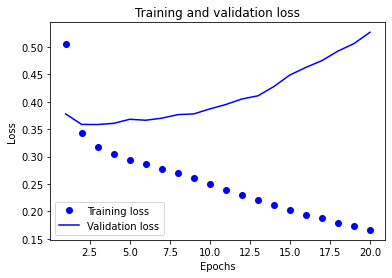

In [11]:
import matplotlib.pyplot as plt
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

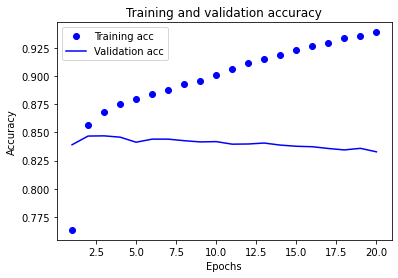

In [12]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

2~3에폭을 넘어가면서 과적합되는 모습을 보입니다. 3에폭을 기준으로 여러가지 모델의 loss와 accuracy를 살펴보겠습니다.

In [13]:
def train_eval(model, name, epochs=3):
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=512,
                        validation_data=(X_val, y_val),
                        verbose=0)
    
    loss, accuracy = model.evaluate(X_test,  y_test, verbose=0)
    print("{}의 loss는 {:.2f}, accuracy는 {:.2f}입니다.".format(name, loss, accuracy))

In [14]:
train_eval(model_rnn, "RNN")
train_eval(model_cnn, "CNN")
train_eval(model_pooling, "MaxPooling")

RNN의 loss는 0.57, accuracy는 0.83입니다.
CNN의 loss는 0.35, accuracy는 0.85입니다.
MaxPooling의 loss는 0.36, accuracy는 0.84입니다.


# Gensim

In [15]:
embedding_layer = model_rnn.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape) 

(10000, 16)


In [16]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 쓴다

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록
vectors = model_rnn.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [17]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

/opt/conda/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


array([-0.05546616, -0.05834755,  0.04018108,  0.02961935,  0.02463697,
       -0.04610871,  0.07545809,  0.02029296,  0.0663607 , -0.07392035,
       -0.02487109, -0.02676513,  0.09568395,  0.04780944, -0.0996773 ,
        0.02735443], dtype=float32)

In [18]:
word_vectors.similar_by_word("공포")

[('스런', 0.778575599193573),
 ('사형수', 0.7611880302429199),
 ('맘마', 0.7569801211357117),
 ('다던', 0.7532618641853333),
 ('마틴', 0.7386524081230164),
 ('메이저', 0.7385995984077454),
 ('미아', 0.7371094822883606),
 ('양심', 0.735809862613678),
 ('잣대', 0.7302115559577942),
 ('유우', 0.7265869379043579)]

공포와 크게 관련 없어보이는 단어들이 높은 유사도를 보입니다. 아직은 벡터가 유의미하게 학습되지 않은 것 같습니다.